## Trying first RL-Agents
-----

https://www.tensorflow.org/agents/tutorials/6_reinforce_tutorial

In [14]:
import numpy as np
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("NO GPU FOUND!")

import src

Defining initial time and state:

In [15]:
from datetime import date
from astropy.time import Time
now = date.today()
# time = Time(now.strftime(r'%Y-%m-%d %H:%M'), scale="utc")
time = Time("2000-01-01 00:00", scale="utc")
walker_name = "mars"

walker_position, walker_velocity = src.get_body_state(walker_name, time).values()

#### Hyperparameters and Environment
------

In [16]:
fc_layer_params = (50, 50, 50)
learning_rate = 1e-4
episodes_per_train_step = 1
episode_length = 1000

n_train_steps = 100

In [17]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments import ActionClipWrapper

system = src.SunSystem(["earth"], initial_time=time)
system.set_smooth = 1e-5
walker = src.Walker(walker_position, walker_velocity, mass=1., name=f"walker ({walker_name})")
solver = src.Solver()
target = tf.constant([0., 0., 1.], dtype=tf.float32)

env = src.WalkerSystemEnv(
    walker, system, solver, target, 
    max_iters=episode_length, 
    step_size=2,
    reward_factor_target_distance=10.,
    reward_factor_boost=0
)
env = ActionClipWrapper(env)
tf_env = TFPyEnvironment(env)

print('Observation Spec:')
print(tf_env.observation_spec()) # train_env.time_step_spec().observation
print('Action Spec:')
print(tf_env.action_spec())

Observation Spec:
{'system-positions': TensorSpec(shape=(2, 3), dtype=tf.float32, name='system-positions'), 'walker-state': TensorSpec(shape=(6,), dtype=tf.float32, name='walker-state'), 'target': TensorSpec(shape=(3,), dtype=tf.float32, name='target')}
Action Spec:
BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='boost', minimum=array(-1.e-04, dtype=float32), maximum=array(1.e-04, dtype=float32))


#### Agent and Policies
-----

In [18]:
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork
from keras.layers import Flatten, Concatenate

obs_specs = tf_env.observation_spec()
pre_layers = {k: Flatten() for k in obs_specs}
pre_combiner = Concatenate(axis=-1)

actor_net = ActorDistributionNetwork(
    input_tensor_spec=obs_specs,
    output_tensor_spec=tf_env.action_spec(),
    preprocessing_layers=pre_layers,    # Must be of the same type (dict in this case) as `input_tensor_spec`
    preprocessing_combiner=pre_combiner,
    fc_layer_params=fc_layer_params
)

value_net = ValueNetwork(
    obs_specs,
    preprocessing_layers=pre_layers,
    preprocessing_combiner=pre_combiner,
)


In [19]:
from tf_agents.agents import PPOAgent
from keras.optimizers import Adam

optimizer = Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

tf_agent = PPOAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter
)
tf_agent.initialize()

In [22]:
tf_env.action_spec()
initial_time_step = tf_env.reset()
print(tf_agent.collect_policy.action(initial_time_step))
print(tf_agent.policy.action(initial_time_step))

BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='boost', minimum=array(-1.e-04, dtype=float32), maximum=array(1.e-04, dtype=float32))

#### Metrics, Replay Buffer, Driver
-----

In [7]:
from tf_agents.metrics import tf_metrics

train_avg_return = tf_metrics.AverageReturnMetric(batch_size=tf_env.batch_size)

In [8]:
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer

replay_buffer = TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=episodes_per_train_step * episode_length + 10
)

In [9]:
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver

collect_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.collect_policy,
    observers=[replay_buffer.add_batch, train_avg_return],
    num_episodes=episodes_per_train_step
)

#### Training Loop
----

In [10]:
# Speeind up:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
tf_agent.train = function(tf_agent.train)

In [11]:
from tqdm import tqdm

losses = []
rewards = []

policy_state = tf_agent.collect_policy.get_initial_state(tf_env.batch_size)

for iteration in tqdm(range(n_iterations)):
    initial_time_step = tf_env.reset()

    time_step, policy_state = collect_driver.run(initial_time_step, policy_state)

    trajectories = replay_buffer.gather_all()

    # print(trajectories.reward.shape)

    reward = trajectories.reward[-1, -1].numpy()
    rewards.append(reward)

    train_loss = tf_agent.train(trajectories)
    loss = train_loss.loss.numpy()
    losses.append(loss)

    replay_buffer.clear()                                                   # TODO: Only for Policy-Gradient Agents

    if (iteration + 1) % (n_iterations // 20) == 0:
        print(
            f"Iteration {iteration + 1}\n" + 
            f"  - loss: {loss:.2f}\n" + 
            f"  - reward after flight: {reward:.2f}"
        )

In [12]:
train_agent(100)

  0%|          | 0/100 [00:00<?, ?it/s]

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


  5%|▌         | 5/100 [01:12<17:58, 11.35s/it]  

Iteration 5
  - loss: 43099.38
  - final reward of last episode: -164.70


 10%|█         | 10/100 [01:56<13:27,  8.97s/it]

Iteration 10
  - loss: 6233.33
  - final reward of last episode: -94.83


 15%|█▌        | 15/100 [02:39<12:23,  8.75s/it]

Iteration 15
  - loss: 5234.62
  - final reward of last episode: -63.39


 20%|██        | 20/100 [03:23<11:38,  8.73s/it]

Iteration 20
  - loss: 3302.78
  - final reward of last episode: -24.70


 25%|██▌       | 25/100 [04:06<10:43,  8.58s/it]

Iteration 25
  - loss: 1370.85
  - final reward of last episode: -10.18


 30%|███       | 30/100 [04:51<10:29,  8.99s/it]

Iteration 30
  - loss: 3130.98
  - final reward of last episode: -34.36


 35%|███▌      | 35/100 [05:34<09:15,  8.54s/it]

Iteration 35
  - loss: 5389.52
  - final reward of last episode: -17.52


 40%|████      | 40/100 [06:17<08:33,  8.56s/it]

Iteration 40
  - loss: 8216.86
  - final reward of last episode: -74.03


 45%|████▌     | 45/100 [07:00<07:51,  8.57s/it]

Iteration 45
  - loss: 550.50
  - final reward of last episode: -9.39


 50%|█████     | 50/100 [07:43<07:03,  8.47s/it]

Iteration 50
  - loss: 495.40
  - final reward of last episode: -30.93


 55%|█████▌    | 55/100 [08:27<06:37,  8.84s/it]

Iteration 55
  - loss: 24224.99
  - final reward of last episode: -288.73


 57%|█████▋    | 57/100 [08:56<06:44,  9.41s/it]


KeyboardInterrupt: 

In [13]:
time_step = tf_env.reset()
for _ in range(1000):
    action = tf_agent.policy.action(time_step).action
    time_step = tf_env._step(action)

In [14]:
plotter = src.Plotter(system=system, walker=walker)
plotter.draw("3d", zrange=None)

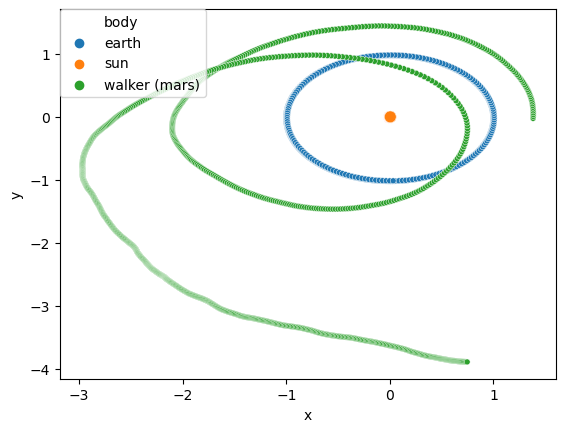

In [15]:
plotter.draw()